In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# visualize graph

from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root, format="svg", rankdir="LR"):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ["LR", "TB"]
    nodes, edges = trace(root)
    dot = Digraph(
        format=format, graph_attr={"rankdir": rankdir}
    )  # , node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(
            name=str(id(n)),
            label="{ %s| data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            # label="{ %s| data %.4f  }" % (n.label, n.data),
            shape="record",
        )
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [3]:
#  so to solve this we'll modify add


# self._prev:  but how are we going to show connectiveness of these numbers as we want to keep expression graphs. to keep track of what values produce other values
# _op='': to track which operation on children created new node


#  building Value Object: data structure to mantain these numerical expressions
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = (
            lambda: None
        )  # for chain rule but by default it doesnot do anything  # a case for leaf node
        self.label = label
        self.grad = 0.0

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(
            self.data + other.data, (self, other), "+"
        )  # here (self, other) are _children

        def _backward():
            self.grad += 1.0 * out.grad  # 1.0 for addition
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other  # Call regular addition method for consistency

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad  # 1.0 for addition
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __rmul__(
        self, other
    ):  # other*self   # this will check if 2*a can not happen, so can a*2 happen?
        # print("rmul")
        return self * other  # changing order and redirecting to __mul__

    def __pow__(self, other):
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad = other * self.data ** (other - 1) * out.grad  # n(x)^(n-1)

        out._backward = _backward

        return out

    def __truediv__(self, other):
        # print(f"self:{self},other:{other}, self * (other ** (-1): {(other * (-1))}")

        return self * (other ** (-1))

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)  # tanh
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def backward(self):

        # topological ordering

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)

                topo.append(v)

        build_topo(self)  # o would be at last o list

        self.grad = 1.0
        for node in reversed(topo):

            node._backward()

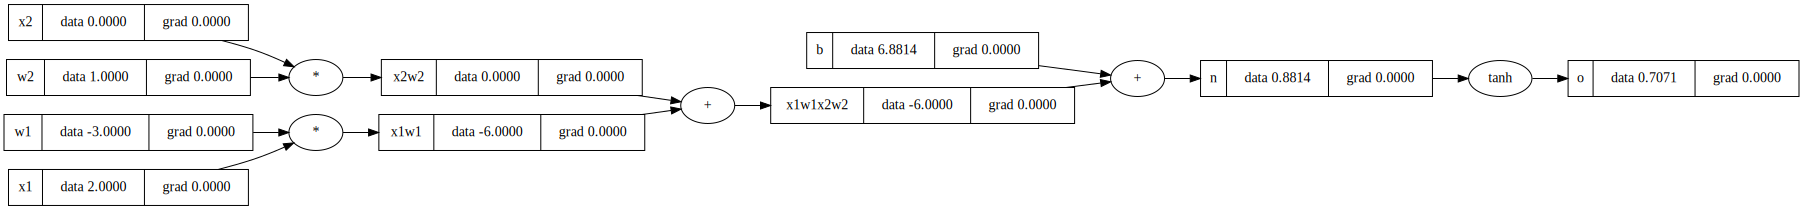

In [4]:
#  a neuron with two inputs: x1,x2

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.88137358, label="b")

x1w1 = x1 * w1
x1w1.label = "x1w1"

x2w2 = x2 * w2
x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1x2w2"
# adding bias
n = x1w1x2w2 + b
n.label = "n"
# activation function
o = n.tanh()
o.label = "o"


draw_dot(o)

# NN


In [5]:
# but grads for input data are not useful because x can not be changed, we will change w,b


import random


class Neuron:
    def __init__(self, nin):  # nin: number of inputs coming to neuron
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        # print(self.w)
        # act = sum(wi * xi for wi, xi in zip(self.w, x)) + self.b
        # or
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)

        out = act.tanh()
        return out

    def parameters(self):  # will retunr parameters agins t each neuron
        return self.w + [self.b]


class Layer:

    def __init__(
        self, nin, nout
    ):  # nout: # of neurons in layer  # nin is input dimensionality of neurons
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params


class MLP:
    def __init__(self, nin, nouts):
        # nouts: list of outputs/neurons## sizes of layer we want in our MLP
        sz = [nin] + nouts

        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
        # print(self.layers)

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


x = [2.0, 3.0, -1]  # 3-dim input
n = MLP(nin=3, nouts=[4, 4, 1])  # three  2 dimensional neurons
n(x)

Value(data=0.986254162330042)

# training


In [6]:
xs = [[2.0, 3.0, -1.0], [3.0, -1, 0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]]


# desired targets
ys = [1.0, 1.0, -1.0, -1.0]
for k in range(30):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])  # ygt- ground truth

    for p in n.parameters():
        p.grad = 0.0

    # backward pass
    loss.backward()

    for p in n.parameters():
        step_size = 0.05
        p.data += -step_size * p.grad

    print(f"epoch:{k}, current_loss={loss.data}")

epoch:0, current_loss=7.645710928827341
epoch:1, current_loss=7.3924043631164045
epoch:2, current_loss=6.375023452842802
epoch:3, current_loss=3.8832968107174985
epoch:4, current_loss=3.502549502836788
epoch:5, current_loss=2.7193306022821075
epoch:6, current_loss=2.1566160739951012
epoch:7, current_loss=2.6467375154874233
epoch:8, current_loss=1.1510411097560265
epoch:9, current_loss=1.3899865214103588
epoch:10, current_loss=1.9955046782803607
epoch:11, current_loss=2.817315493091158
epoch:12, current_loss=0.6790974416521447
epoch:13, current_loss=0.5239381416011567
epoch:14, current_loss=0.41218808695423875
epoch:15, current_loss=0.3233065316682334
epoch:16, current_loss=0.25758147769149864
epoch:17, current_loss=0.2090483185613763
epoch:18, current_loss=0.1775502981884426
epoch:19, current_loss=0.15445771791308072
epoch:20, current_loss=0.13627488830453172
epoch:21, current_loss=0.12147680936285374
epoch:22, current_loss=0.10923949288145068
epoch:23, current_loss=0.09898842642980571

In [7]:
ypred

[Value(data=0.8579044422751264),
 Value(data=0.9025394494323475),
 Value(data=-0.9357633401625642),
 Value(data=-0.8332504530053186)]